# Graphs and Networks in Linear Algebra

This notebook is based on section 10.1 of Strang's *Linear Algebra* textbook.

One interesting source of large matrices in linear algebra is a [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics), a collection of *nodes* (vertices) and *edges* (arrows from one vertex to another).   Graphs are used in many applications to represent *relationships* and *connectivity*, such as:

* For computer networks, nodes could represent web pages, and edges could represent links.
* For circuits, edges could represent wires (or resistors) and nodes junctions.
* For transportation, nodes could represent cities and edges roads.
* In bioinformatics, graphs can represent gene regulatory networks.
* In sociology, nodes could represent people and edges relationships.
* ... and many, many other applications ...

In this notebook, we explain how a graph can be represented by a *matrix*, and how linear algebra can tell us properties of the graph and can help us do computations on graph-based problems.  There is a particularly beautiful connection to Kirchhoff's laws of circuit theory.

## Packages for this notebook

To run the code in this notebook, you'll need to install a few Julia packages used below.  To do so, uncomment the following line and run it:

In [1]:
# Pkg.add.(["LightGraphs", "MetaGraphs", "GraphPlot", "NamedColors", "RowEchelon", Interact", "SymPy"])

...and then run this cell to import the packages:

In [2]:
using Interact, RowEchelon, LightGraphs, MetaGraphs, GraphPlot, NamedColors, LinearAlgebra
import SymPy
using SymPy: Sym

HTML{String}("    <script id=\"webio-setup-2532233624759935175\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-5035077655054867987\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-2532233624759935175\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/62410a6b2cb49fb072163a2752687141fb839b23-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/62410a6b2cb49fb072163a2752687141fb839b23-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-5035077655054867987\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

## Julia Graph-visualization code

There are several Julia packages for manipulating graphs, e.g. [LightGraphs](https://github.com/JuliaGraphs/LightGraphs.jl), along with several packages for visualizing graphs, e.g. [GraphViz](https://github.com/Keno/GraphViz.jl).  LightGraphs is oriented towards fast and sophisticated graph computations, however, and here I just want to do some simple and pretty visualizations with simple algorithms based on those in Strang's 18.06 textbook.

So, here I define a simple `MyGraph` wrapper around LightGraphs directed graphs, with metadata attached via the MetaGraphs package, for basic plotting via the GraphPlots package.

In [3]:
struct MyGraph
    g::MetaDiGraph
end
Base.copy(mg::MyGraph) = MyGraph(copy(mg.g))
function MyGraph(edges::Pair{<:Integer,<:Integer}...)
    g = SimpleDiGraphFromIterator(Edge(e) for e in edges)
    MyGraph(MetaDiGraph(g))
end

using Random
function deterministic_spring_layout(g::AbstractGraph; seed::Integer=0, kws...)
    rng = MersenneTwister(seed)
    spring_layout(g, 2 .* rand(rng, nv(g)) .- 1.0, 2 .* rand(rng,nv(g)) .- 1.0; kws...)
end
function Base.show(io::IO, m::MIME"image/svg+xml", mg::MyGraph)
    show(io, m, 
         gplot(mg.g, layout=deterministic_spring_layout,
               nodelabel=map(v -> get(MetaGraphs.props(mg.g, v), :label, v), vertices(mg.g)),
               nodefillc=map(v -> get(MetaGraphs.props(mg.g, v), :color, "gray"), vertices(mg.g)),
               edgelabel=map(ie -> get(MetaGraphs.props(mg.g, ie[2]), :label, ie[1]), enumerate(edges(mg.g))),
               edgestrokec=map(e -> get(MetaGraphs.props(mg.g, e), :color, "lightgray"), edges(mg.g)),
         ))
end

function nodecolors!(g::MyGraph, nodes::AbstractVector{<:Integer}, color::String="red")
    for n in nodes
        set_prop!(g.g, n, :color, color)
    end
    g
end
nodecolors(g, nodes, color) = nodecolors!(copy(g), nodes, color)
edgearr(g, e) = e
edgearr(g, e::AbstractVector{<:Integer}) = collect(edges(g))[e]
edgearr(g, e::AbstractVector{<:Pair}) = Edge.(e)
function edgecolors!(g::MyGraph, edges::AbstractVector, color::String="red")
    for e in edgearr(g.g, edges)
        set_prop!(g.g, e, :color, color)
    end
    g
end
edgecolors(g::MyGraph, edges::AbstractVector, color::String="red") = edgecolors!(copy(g), edges, color)

# A little code so that we can label graph nodes/edges with SymPy expressions.
# convert strings like "v_2 - v_0" from SymPy to nicer Unicode strings like "v₂ - v₀"
subchar(d::Integer) = Char(UInt32('₀')+d)
subchar(c::Char) = subchar(UInt32(c)-UInt32('0'))
subchar(s::String) = replace(s, r"_[0-9]" => s -> subchar(s[2]))
labelstring(s::SymPy.Sym) = subchar(repr("text/plain", s))
labelstring(x) = x

function labels!(g::MyGraph; edges=nothing, nodes=nothing)
    if edges !== nothing
        for (e,E) in zip(MetaGraphs.edges(g.g), edges)
            set_prop!(g.g, e, :label, labelstring(E))
        end
    end
    if nodes !== nothing
        for (n,N) in zip(vertices(g.g), nodes)
            set_prop!(g.g, n, :label, labelstring(N))
        end
    end
    g
end
labels(g::MyGraph; kws...) = labels!(copy(g); kws...)

labels (generic function with 1 method)

In [4]:
# generate a random graph with a given average #edges per node
function randgraph(numnodes::Integer, edgespernode::Real)
    p = edgespernode/numnodes # probability of each edge
    e = Vector{Pair{Int,Int}}()
    for i = 1:numnodes, j = 1:numnodes
        if i != j && rand() < p
            push!(e, i=>j)
        end
    end
    return MyGraph(e...)
end

randgraph (generic function with 1 method)

In [5]:
# returns the incidence matrix for g
function incidence(g::MyGraph)
    A = zeros(Int, ne(g.g), nv(g.g))
    for (i,e) in enumerate(edges(g.g))
        A[i,e.src] = -1
        A[i,e.dst] = +1
    end
    return A
end

incidence (generic function with 1 method)

In [6]:
# Find the loops in g by the simplest "textbook" manner:
# get a basis for the left nullspace incidence matrix.
# We do this via the rref form, rather than nullspace(A'), because
# we want a "nice" basis of ±1 and 0 entries.
function leftnullspace(g::MyGraph)
    A = incidence(g)
    R = rref(Matrix(A'))
    m, n = size(R)
    pivots = Int[]
    for i = 1:m
        j = findfirst(!iszero, R[i,:])
        j !== nothing && push!(pivots, j)
    end
    r = length(pivots) # rank
    free = Int[j for j=1:n if j ∉ pivots]
    N = zeros(Int, n, n-r)
    k = 0
    for (k,j) in enumerate(free)
        N[pivots, k] = -R[1:r, j]
        N[j, k] = 1
    end
    return N
end

leftnullspace (generic function with 1 method)

In [7]:
# color the edges of a spanning tree of g, by the textbook
# method of finding the pivot rows of the incidence matrix
function pivotrows(g::MyGraph)
    A = incidence(g)
    R = rref(Matrix(A'))
    m, n = size(R)
    pivots = Int[]
    for i = 1:m
        j = findfirst(!iszero, R[i,:])
        j !== nothing && push!(pivots, j)
    end
    return pivots
end
colortree(g::MyGraph, color::String="red") = edgecolors(g, pivotrows(g), color)
tree(g::MyGraph) = MyGraph(MetaDiGraph(SimpleDiGraphFromIterator(edgearr(g.g, pivotrows(g)))))

tree (generic function with 1 method)

## Graphs and incidence matrices

Let's start by looking at an example graph with 6 nodes 8 edges.  Computers are pretty good at drawing graphs for us:

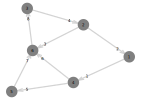

In [8]:
g = MyGraph(1=>4, 4=>5, 5=>6, 6=>3, 3=>2, 2=>1, 2=>6, 4=>6)

A key way to represent a graph in linear algebra is the [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix).  As defined in Strang's textbook, this is a matrix where the **rows correspond to edges** and the **columns correspond to nodes**.  (Some authors use the transpose of this instead.)

In particular, in the row for each edge going **from node N to node M**, there is a **-1 in column N** and a **+1 in column N**.

For example, the incidence matrix of the graph above is:

In [9]:
A = incidence(g)

8×6 Array{Int64,2}:
 -1   0   0   1   0   0
  1  -1   0   0   0   0
  0  -1   0   0   0   1
  0   1  -1   0   0   0
  0   0   0  -1   1   0
  0   0   0  -1   0   1
  0   0   0   0  -1   1
  0   0   1   0   0  -1

There is an interesting structure if you think about *loops* in the graph.  For example, in the graph above there is a loop among nodes 6, 3, 2, via edges 4,3,8.  Let's look at the rows of $A$ corresponding to those edges:

In [10]:
A[[4,3,8],:]

3×6 Array{Int64,2}:
 0   1  -1  0  0   0
 0  -1   0  0  0   1
 0   0   1  0  0  -1

If we **add these rows** we get **zero**:

In [11]:
A[4,:]' + A[3,:]' + A[8,:]'

1×6 Adjoint{Int64,Array{Int64,1}}:
 0  0  0  0  0  0

In general, it is easy to see that **any loop in the graph** corresponds to **dependent rows**: if we sum the rows going around the loop (with a minus sign for arrows in the wrong direction), we get zero.

The reason is simple: we get a -1 in a column when we *leave* a node, and a +1 in the column when we *enter* a node.  When we go around the loop, we leave and enter each node, so the sum is zero.

But dependent rows correspond to **elements of the left nullspace**:

In [12]:
[0 0 1 1 0 0 0 1] * A

1×6 Array{Int64,2}:
 0  0  0  0  0  0

That means that the number of "independent" (primitive) loops in a graph is related to the **rank** of the incidence matrix, and the **independent rows of A have no loops**.

Let's look at the row-reduced echelon (rref) form of $A^T$:

In [13]:
Matrix{Int}(rref(Matrix(A')))

6×8 Array{Int64,2}:
 1  0  0  0  0  -1  -1   0
 0  1  0  0  0  -1  -1   0
 0  0  1  0  0   1   1  -1
 0  0  0  1  0   0   0  -1
 0  0  0  0  1   0  -1   0
 0  0  0  0  0   0   0   0

We can see that the rank of $A$ is 5:

In [14]:
rank(A)

5

This means that there are **five loop-free (independent) edges**, and there are **three** (8 - 5) primitive loops.  Using the rref form of $A^T$, we can read off a basis for the left nullspace from the free columns (6,7,8):

In [15]:
N = leftnullspace(g)

8×3 Array{Int64,2}:
  1   1  0
  1   1  0
 -1  -1  1
  0   0  1
  0   1  0
  1   0  0
  0   1  0
  0   0  1

In [16]:
A' * N

6×3 Array{Int64,2}:
 0  0  0
 0  0  0
 0  0  0
 0  0  0
 0  0  0
 0  0  0

Let's visualize these loops by plotting the edges in a different color (red) one by one,
with help from the Interact package to give us an interactive widget:

In [17]:
colorloop(g::MyGraph, n::Vector) = edgecolors!(edgecolors(g, findall(n .> 0), "red"), findall(n .< 0), "blue")
function animloops(g::MyGraph)
    L = leftnullspace(g)
    @manipulate for loop in 1:size(L,2)
        colorloop(g, L[:,loop])
    end
end

animloops (generic function with 1 method)

In [18]:
animloops(g)

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:loop=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
2), Observable{Int64} with 2 listeners. Value:
2, Scope("knockout-component-5e5894c4-4d5a-4120-94d2-9404bbe983c5", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["loop"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>3,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
2, nothing)), Set(String[]), nothing, Any["knockout"=>"/Users/stevenj/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/Users/stevenj/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/Users/stevenj/.julia/packages/InteractBase/Q4IkI/src/../assets/all.js", "/Users/stevenj/.julia/packages/InteractBase/Q4IkI/src/../assets/style.css", "/Users/stevenj/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":2}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (_webIOScope.setObservableValue({\"name\":\"changes\",\"scope\":\"knockout-component-5e5894c4-4d5a-4120-94d2-9404bbe983c5\",\"id\":\"ob_02\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (_webIOScope.setObservableValue({\"name\":\"value\",\"scope\":\"knockout-component-5e5894c4-4d5a-4120-94d2-9404bbe983c5\",\"id\":\"ob_01\",\"type\":\"observable\"},val)) : undefined; return this.va

These three loops are **not the only loops** in the graph, but the **other loops can be made from combinations of these loops**.  (Similarly, the columns of $N$ are not the *whole* left nullspace, they are just a **basis** for the n nullspace.

For example, the loop between nodes 1-4-5-6-3-2  can be made by starting with 1-4-5-6-2 and "adding" the 6-3-2 loop.

In this sense, a basis for the left nullspace of $A$ is a "basis" for the other loops in the graph: we say that they are "primitive" loops.

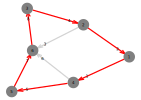

In [19]:
colorloop(g, N[:,2] + N[:,3]) # add two loops to make another loop

It is fun to do the same thing for bigger graphs, chosen at random:

In [20]:
gbig = randgraph(15, 2)
animloops(gbig)

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:loop=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
5), Observable{Int64} with 2 listeners. Value:
5, Scope("knockout-component-445c54a5-22cf-48aa-bc7e-a2492035de0f", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["loop"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>9,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
5, nothing)), Set(String[]), nothing, Any["knockout"=>"/Users/stevenj/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/Users/stevenj/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/Users/stevenj/.julia/packages/InteractBase/Q4IkI/src/../assets/all.js", "/Users/stevenj/.julia/packages/InteractBase/Q4IkI/src/../assets/style.css", "/Users/stevenj/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":5}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (_webIOScope.setObservableValue({\"name\":\"changes\",\"scope\":\"knockout-component-445c54a5-22cf-48aa-bc7e-a2492035de0f\",\"id\":\"ob_09\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (_webIOScope.setObservableValue({\"name\":\"value\",\"scope\":\"knockout-component-445c54a5-22cf-48aa-bc7e-a2492035de0f\",\"id\":\"ob_08\",\"type\":\"observable\"},val)) : undefined; return this.va

Conversely, the *independent* rows of $A$ (corresponding to the **pivot columns** of the rref form of $A^T$) form a **maximal set of edges with no loops**.  A graph with no loops is called a [tree](https://en.wikipedia.org/wiki/Tree_(graph_theory)), and this particular tree is called a [spanning tree](https://en.wikipedia.org/wiki/Spanning_tree) because it touches all of ("spans") the nodes (assuming the graph is connected).

Let's color the spanning tree (loop-free edges) of our example graph red:

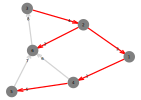

In [21]:
colortree(g)

We can also discard all of the edges that are *not* in the spanning tree, and we are left with a more boring graph of *just* the spanning tree:

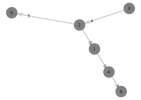

In [22]:
tree(g)

We can do the same thing for our bigger random example:

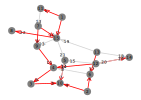

In [23]:
colortree(gbig)

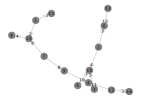

In [24]:
tree(gbig)

And we can make trees from even larger graphs, for fun:

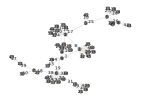

In [25]:
tree(randgraph(50, 8))

## Graphs and Kirchhoff's circuit laws



An elegant application of the incidence matrix and its subspaces arises if we think of the graph as representing an **electrical circuit**:

* Each edge represents a wire/resistor, with an unknown current $i$.  The *direction* of the edge indicates the *sign convention* ($i>0$ indicates current flowing in the direction of the arrow).
* Each node represents a junction, with an unknown voltage $v$.

Let's visualize this by re-labeling our graph from above.  We'll use the [SymPy](https://github.com/JuliaPy/SymPy.jl) package to allow us to do *symbolic* (not numeric) calculations with the incidence matrix.

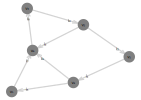

In [26]:
labels(g, edges=[Sym("i_$i") for i = 1:size(A,1)], nodes=[Sym("v_$i") for i = 1:size(A,2)])

### Kirchhoff's voltage law (KVL)

Let's start doing some linear algebra.  What happens if we *multiply* our incidence matrix $A$ by a vector of voltages, one per node?

In [27]:
v = [Sym("v_$i") for i = 1:size(A,2)]

6-element Array{Sym,1}:
 v_1
 v_2
 v_3
 v_4
 v_5
 v_6

In [28]:
A

8×6 Array{Int64,2}:
 -1   0   0   1   0   0
  1  -1   0   0   0   0
  0  -1   0   0   0   1
  0   1  -1   0   0   0
  0   0   0  -1   1   0
  0   0   0  -1   0   1
  0   0   0   0  -1   1
  0   0   1   0   0  -1

In [29]:
A * v

8-element Array{Sym,1}:
 -v_1 + v_4
  v_1 - v_2
 -v_2 + v_6
  v_2 - v_3
 -v_4 + v_5
 -v_4 + v_6
 -v_5 + v_6
  v_3 - v_6

What we get are the **voltage difference** (and in particular, the **voltage rise**) across each edge.  It is easier to see this if we use the elements of $Av$ to directly label the edges of our graph:

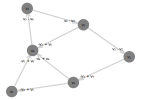

In [30]:
labels(g, edges=A*v, nodes=v)

Now, let's ask the inverse question: **what voltage differences $d=Av$** can possibly arise?  i.e. what $d$ are in $C(A)$? 

Remember, $A$ is **not full rank**: its rank is 5, but there are 8 rows (8 edges).  So, $C(A)$ is 5-dimensional ("missing" three dimensions).  Equivalently $C(A)$ is **orthogonal to the left nullspace**, which has three rows.  What does this mean?

Let's visualize the differences d:

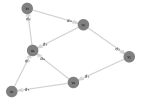

In [31]:
d = [Sym("d_$j") for j = 1:size(A,1)]
labels(g, edges=d, nodes=v)

If $N$ is a basis for the left nullspace, we must have $N^T d = 0$, or:

In [32]:
N' * d

3-element Array{Sym,1}:
       d_1 + d_2 - d_3 + d_6
 d_1 + d_2 - d_3 + d_5 + d_7
             d_3 + d_4 + d_8

But what is this?  Remember, each element of the left nullspace corresponded to a **loop in the graph**.  Saying $N^T d = 0$, or $d \perp N(A^T)$, is equivalent to saying that the **sum of the voltage rises around each loop = 0**.

But this is precisely [Kirchhoff's voltage law](https://en.wikipedia.org/wiki/Kirchhoff's_circuit_laws) from circuit theory!

### Kirchhoff's current law (KCL)

To actually solve circuit problems, we need three additional ingredients:

* The voltage difference $d$ must be divided by a resistance $R$ to get the *current* $i$ through that edge: $i = -d/R = -Yd$ (where $Y=1/R$ is the "admittance"), by [Ohm's law](https://en.wikipedia.org/wiki/Ohm's_law).  Note that we need a minus sign to get the current in the direction of the arrow, since $d$ was the the voltage *rise* across the edge.

* The sum of the currents $i$ entering each node must be zero, by Kirchhoff's current law (KCL).

* To get a nontrivial solution, we need some kind of *source*: a battery or current source, to start currents flowing.

How do we represent each one of these steps by linear-algebra operations?

#### Ohm's law

To represent Ohm's law, we need to multiply the voltage differences $d=Av$ by a *diagonal matrix* of admittances:

In [33]:
Y = diagm(0=>[Sym("Y_$i") for i = 1:size(A,1)])

8×8 Array{Sym,2}:
 Y_1    0    0    0    0    0    0    0
   0  Y_2    0    0    0    0    0    0
   0    0  Y_3    0    0    0    0    0
   0    0    0  Y_4    0    0    0    0
   0    0    0    0  Y_5    0    0    0
   0    0    0    0    0  Y_6    0    0
   0    0    0    0    0    0  Y_7    0
   0    0    0    0    0    0    0  Y_8

In [34]:
Y*d

8-element Array{Sym,1}:
 Y_1*d_1
 Y_2*d_2
 Y_3*d_3
 Y_4*d_4
 Y_5*d_5
 Y_6*d_6
 Y_7*d_7
 Y_8*d_8

In [35]:
Y*A*v

8-element Array{Sym,1}:
 -Y_1*v_1 + Y_1*v_4
  Y_2*v_1 - Y_2*v_2
 -Y_3*v_2 + Y_3*v_6
  Y_4*v_2 - Y_4*v_3
 -Y_5*v_4 + Y_5*v_5
 -Y_6*v_4 + Y_6*v_6
 -Y_7*v_5 + Y_7*v_6
  Y_8*v_3 - Y_8*v_6

#### Net current into each node

Given the currents $i$, a little thought shows that the net current flowing into each node is precisely $A^T i$:

In [36]:
i = [Sym("i_$j") for j=1:size(A,1)]
A'*i

6-element Array{Sym,1}:
            -i_1 + i_2
      -i_2 - i_3 + i_4
            -i_4 + i_8
       i_1 - i_5 - i_6
             i_5 - i_7
 i_3 + i_6 + i_7 - i_8

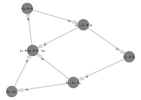

In [37]:
labels(g, edges=i, nodes=A'*i)

Why is this?  The reason is that each row $A^T$ corresponds to a node, and has $\pm 1$ for each edge going into or out of the node, exactly the right sign to sum the net currents flowing in:

In [38]:
A'

6×8 Adjoint{Int64,Array{Int64,2}}:
 -1   1   0   0   0   0   0   0
  0  -1  -1   1   0   0   0   0
  0   0   0  -1   0   0   0   1
  1   0   0   0  -1  -1   0   0
  0   0   0   0   1   0  -1   0
  0   0   1   0   0   1   1  -1

Putting it together, given voltages $v$, the net current flowing **out of** each node is

$$
A^T Y A v
$$

The matrix $A^T Y A$ is a very special and important kind of matrix.  It is obviously **symmetric**, and later on in the course we will see that any matrix of this form is necessarily **positive semidefinite** (all pivots are ≥ 0).   Many important matrices in science, engineering, statistics, and other fields take on this special form.

If we multiply $A^T Y A$ together, not all of its specialness is apparent.  It is often better to leave it in "factored" form:

In [39]:
A' * Y * A

6×6 Array{Sym,2}:
 Y_1 + Y_2             -Y_2          0  …          0                      0
      -Y_2  Y_2 + Y_3 + Y_4       -Y_4             0                   -Y_3
         0             -Y_4  Y_4 + Y_8             0                   -Y_8
      -Y_1                0          0          -Y_5                   -Y_6
         0                0          0     Y_5 + Y_7                   -Y_7
         0             -Y_3       -Y_8  …       -Y_7  Y_3 + Y_6 + Y_7 + Y_8

#### Null space

If we just say that the net current flowing out of each node is zero, we get the equation:
$$
A^T Y A v = 0
$$
or $v \in N(A^T Y A) = N(A)$.

It is an amazing and important fact that $N(A^T Y A) = N(A)$!!  (You saw a version of this in homework.)   Why is this?  Clearly, if $Ax = 0$ then $A^T Y Ax=0$.  But what about the converse?  Here is a trick: if $A^T Y Ax =0$, then $x^T A^T Y A x=0 = (Ax)^T Y (Ax)$.  Let $y=Ax$.  It is easy to see that $y^T Y y = \sum_i Y_i y_i^2 = 0$ only if $y=0$, since all of the admittances $Y_i$ are positive.  (We will later say that $Y$ is a "positive-definite matrix".)  This means that $A^T Y Ax =0$ implies that $y=Ax=0$, which implies that $x \in N(A)$.

What is $N(A)$? The rank of $A$ is 5, so $N(A)$ must be **1-dimensional**.  A basis for it is:

In [40]:
nullspace(A)

6×1 Array{Float64,2}:
 -0.4082482904638629 
 -0.408248290463863  
 -0.4082482904638628 
 -0.40824829046386313
 -0.4082482904638631 
 -0.4082482904638629 

But this is, of course, just the space of vectors where **all voltages are equal**.   In hindsight, this should be obvious: if all the voltages are equal, then their difference are zero, and the currents are zero, and KCL is satisfied.

### Current sources

Of course, it is much more interesting to think about circuits when the currents are nonzero!

To do this, we must consider a **source term** in the equations, and in particular we could try to solve

$$
A^T Y A v = s
$$

for some $s\ne 0$.  What does $s$ represent?  It is precisely an **external source of current** flowing **out of each node**.

For this to have a solution, however, we must have $s \in C(A^T Y A) = N((A^T Y A)^T)^\perp = N(A^T Y A)^\perp = N(A)^\perp$ (since $A^T Y A$ is symmetric, the left and right nullspaces are equal).  We know a basis for $N(A)$ from above, so this boils down to:

$$
\begin{pmatrix} 1 & 1 & 1 & 1 & 1 & 1 \end{pmatrix} s = 0 = \sum_{i=1}^6 s_i
$$

That is, to have a solution, **all current that flows in must flow out**, so that the net current flowing into the circuit is zero.  This makes a lot of physical sense!

Just for fun, let's solve this circuit problem when the current is flowing **into node 2** and **out through node 1**, with slider controls for the 8 admittances, and label the edges with the currents.

In [41]:
twodigits(x) = round(x, digits=2)

twodigits (generic function with 1 method)

In [42]:
@manipulate for Y₁=0.1:0.1:10,
                Y₂=0.1:0.1:10,
                Y₃=0.1:0.1:10,
                Y₄=0.1:0.1:10,
                Y₅=0.1:0.1:10,
                Y₆=0.1:0.1:10,
                Y₇=0.1:0.1:10,
                Y₈=0.1:0.1:10
    s = [1,-1,0,0,0,0]
    Y = diagm(0=>[Y₁,Y₂,Y₃,Y₄,Y₅,Y₆,Y₇,Y₈])
    nodecolors!(labels(g, edges=[subchar("i_$j = $i") for (j,i) in enumerate(twodigits.(Y*A*(pinv(A'*Y*A) * s)))]),
                [1,2])
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:Y₁=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
50,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"  …  "9.1", "9.2", "9.3", "9.4", "9.5", "9.6", "9.7", "9.8", "9.9", "10.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"5.0",:value=>Observable{Float64} with 2 listeners. Value:
5.0), Observable{Float64} with 2 listeners. Value:
5.0, Scope("knockout-component-37f6044d-c8f8-407d-8d44-d8198f960e0e", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["Y₁"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>100,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"  …  "9.1", "9.2", "9.3", "9.4", "9.5", "9.6", "9.7", "9.8", "9.9", "10.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"5.0", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
50, nothing)), Set(String[]), nothing, Any["knockout"=>"/Users/stevenj/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/Users/stevenj/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/Users/stevenj/.julia/packages/InteractBase/Q4IkI/src/../assets/all.js", "/Users/stevenj/.julia/packages/InteractBase/Q4IkI/src/../assets/style.css", "/Users/stevenj/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"formatted_vals\\\":[\\\"0.1\\\",\\\"0.2\\\",\\\"0.3\\\",\

Notice that if we make the admittance $Y_2$ really large compared to all of the other admittances, then nearly all of the current should flow just over that one edge.   Conversely, if we make $Y_2$ really *small*, it is almost like "cutting" that wire: almost all of the current should flow through the *other* edges.

Hooray, math (and physics) works!

## Sparsity

The case of matrices arising from graphs illustrates another point that I've made many times: **really large matrices are often sparse (mostly 0)** in practice.

For example, imagine a circuit with a million nodes.  For the most part, there will only be *wires between nearby nodes*.  Or imagine a graph where the nodes are websites and the edges are links: there are billions of sites, but *each site only links to a few other sites* (a few hundred at most, usually).   In such cases, the **incidence matrix is mostly zero**, and similarly for $A^T Y A$ etcetetera.

This is hugely important, because solving $Ax=b$ and most other matrix equations scale as $\sim n^3$ for $n \times n$ matrices.  $1000 \times 1000$ matrices are easy (< 1 second), but $n=10^6$ would require supercomputers, and $n=10^9$ would be impossibly hard.   What saves us is that there are **much faster algorithms for sparse matrices**.  We won't learn much about such algorithms in 18.06, but the key point is to know that they exist.

If you encounter a large sparse matrix problem in the future, go read about sparse matrix algorithms!